# load dataset

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 256kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 765kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.20MB/s]


# train

In [ ]:
import torch
from einops import rearrange
from torch.optim import AdamW
from tqdm import tqdm

def warp_time(t, dt=None, s=.25):
    # https://drscotthawley.github.io/blog/posts/FlowModels.html#more-points-where-needed-via-time-warping
    tw = 4*(1-s)*t**3 + 6*(s-1)*t**2 + (3-2*s)*t 
    if dt:
        return tw,  dt * 12*(1-s)*t**2 + 12*(s-1)*t + (3-2*s) 
    return tw

def train(
    model, 
    dataloader, 
    num_epochs=10,
    lr=1e-4,
    device='cuda'
):
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for _, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)
            x = x.squeeze()
            patchified_latents = rearrange(x, "b (h p1) (w p2) -> b (h w) (p1 p2)", p1=4, p2=4)

            t = torch.rand(x.shape[0], device=x.device)
            t = warp_time(t)

            flow, noise = model(patchified_latents, t)
            target_flow = noise - patchified_latents

            loss = ((flow - target_flow) ** 2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}')

In [4]:
from model.flextok import FlexTokMnistConfig, FlexTok

device = "cuda"
cfg = FlexTokMnistConfig()
model = FlexTok(cfg)
model.to(device);
train(model, train_loader, num_epochs=10, lr=1e-4)

Epoch 1/10: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.4501]


Epoch 1 - Avg Loss: 0.7900


Epoch 2/10: 100%|██████████| 938/938 [00:58<00:00, 16.16it/s, loss=0.4193]


Epoch 2 - Avg Loss: 0.4752


Epoch 3/10: 100%|██████████| 938/938 [00:57<00:00, 16.31it/s, loss=0.4045]


Epoch 3 - Avg Loss: 0.4250


Epoch 4/10: 100%|██████████| 938/938 [00:58<00:00, 15.90it/s, loss=0.3921]


Epoch 4 - Avg Loss: 0.3806


Epoch 5/10: 100%|██████████| 938/938 [01:02<00:00, 14.93it/s, loss=0.3237]


Epoch 5 - Avg Loss: 0.3491


Epoch 6/10: 100%|██████████| 938/938 [00:59<00:00, 15.76it/s, loss=0.2605]


Epoch 6 - Avg Loss: 0.3236


Epoch 7/10: 100%|██████████| 938/938 [00:57<00:00, 16.30it/s, loss=0.2769]


Epoch 7 - Avg Loss: 0.3006


Epoch 8/10: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s, loss=0.3432]


Epoch 8 - Avg Loss: 0.2837


Epoch 9/10: 100%|██████████| 938/938 [00:59<00:00, 15.87it/s, loss=0.3020]


Epoch 9 - Avg Loss: 0.2706


Epoch 10/10: 100%|██████████| 938/938 [00:57<00:00, 16.30it/s, loss=0.2829]

Epoch 10 - Avg Loss: 0.2594


In [ ]:
torch.save(model.state_dict(), "mnist_flow.pt")

In [ ]:
import torch
from model.flextok import FlexTokMnistConfig, FlexTok

device = "cuda"
cfg = FlexTokMnistConfig()
model = FlexTok(cfg)
model.to(device);

model.load_state_dict(torch.load("mnist_flow.pt"))

In [5]:
import torch
from einops import rearrange

def rk4_step(f, # function that takes (y,t) and returns dy/dt, i.e. velocity
             y, # current location
             t, # current t value
             dt, # requested time step size 
             ):
    k1 =  f(y, t)
    k2 =  f(y - dt*k1/2, t + dt/2) 
    k3 =  f(y - dt*k2/2, t + dt/2) 
    k4 =  f(y - dt*k3, t + dt) 
    return (k1 + 2*k2 + 2*k3 + k4)/6

def fwd_euler_step(model, current_points, current_t, dt):
    velocity = model(current_points, current_t)
    return velocity

@torch.no_grad
def generate_images(model, starting_noise, registers, method, denoising_steps, img_rearrange=True):

    current_images = starting_noise.clone()
    ts = torch.linspace(0, 1, denoising_steps).to(registers.device)

    def f(y, t):
        return model.decoder(registers, y, t)

    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
        timestep = rearrange(ts[i], " -> 1")
        pred_flow = method(f, current_images, timestep, dt)

        current_images -= dt * pred_flow

    if img_rearrange:
        current_images = rearrange(current_images, "b (h w) (p1 p2) -> b (h p1) (w p2)", h=7, w=7, p1=4, p2=4)
    
    return current_images

@torch.no_grad
def gen(model, x, denoising_steps):
    x = rearrange(x, "b (h p1) (w p2) -> b (h w) (p1 p2)", p1=4, p2=4)
    noise = torch.randn_like(x)
    registers = model.encode(x)
    images = generate_images(model, noise, registers, rk4_step, denoising_steps=denoising_steps)
    return images

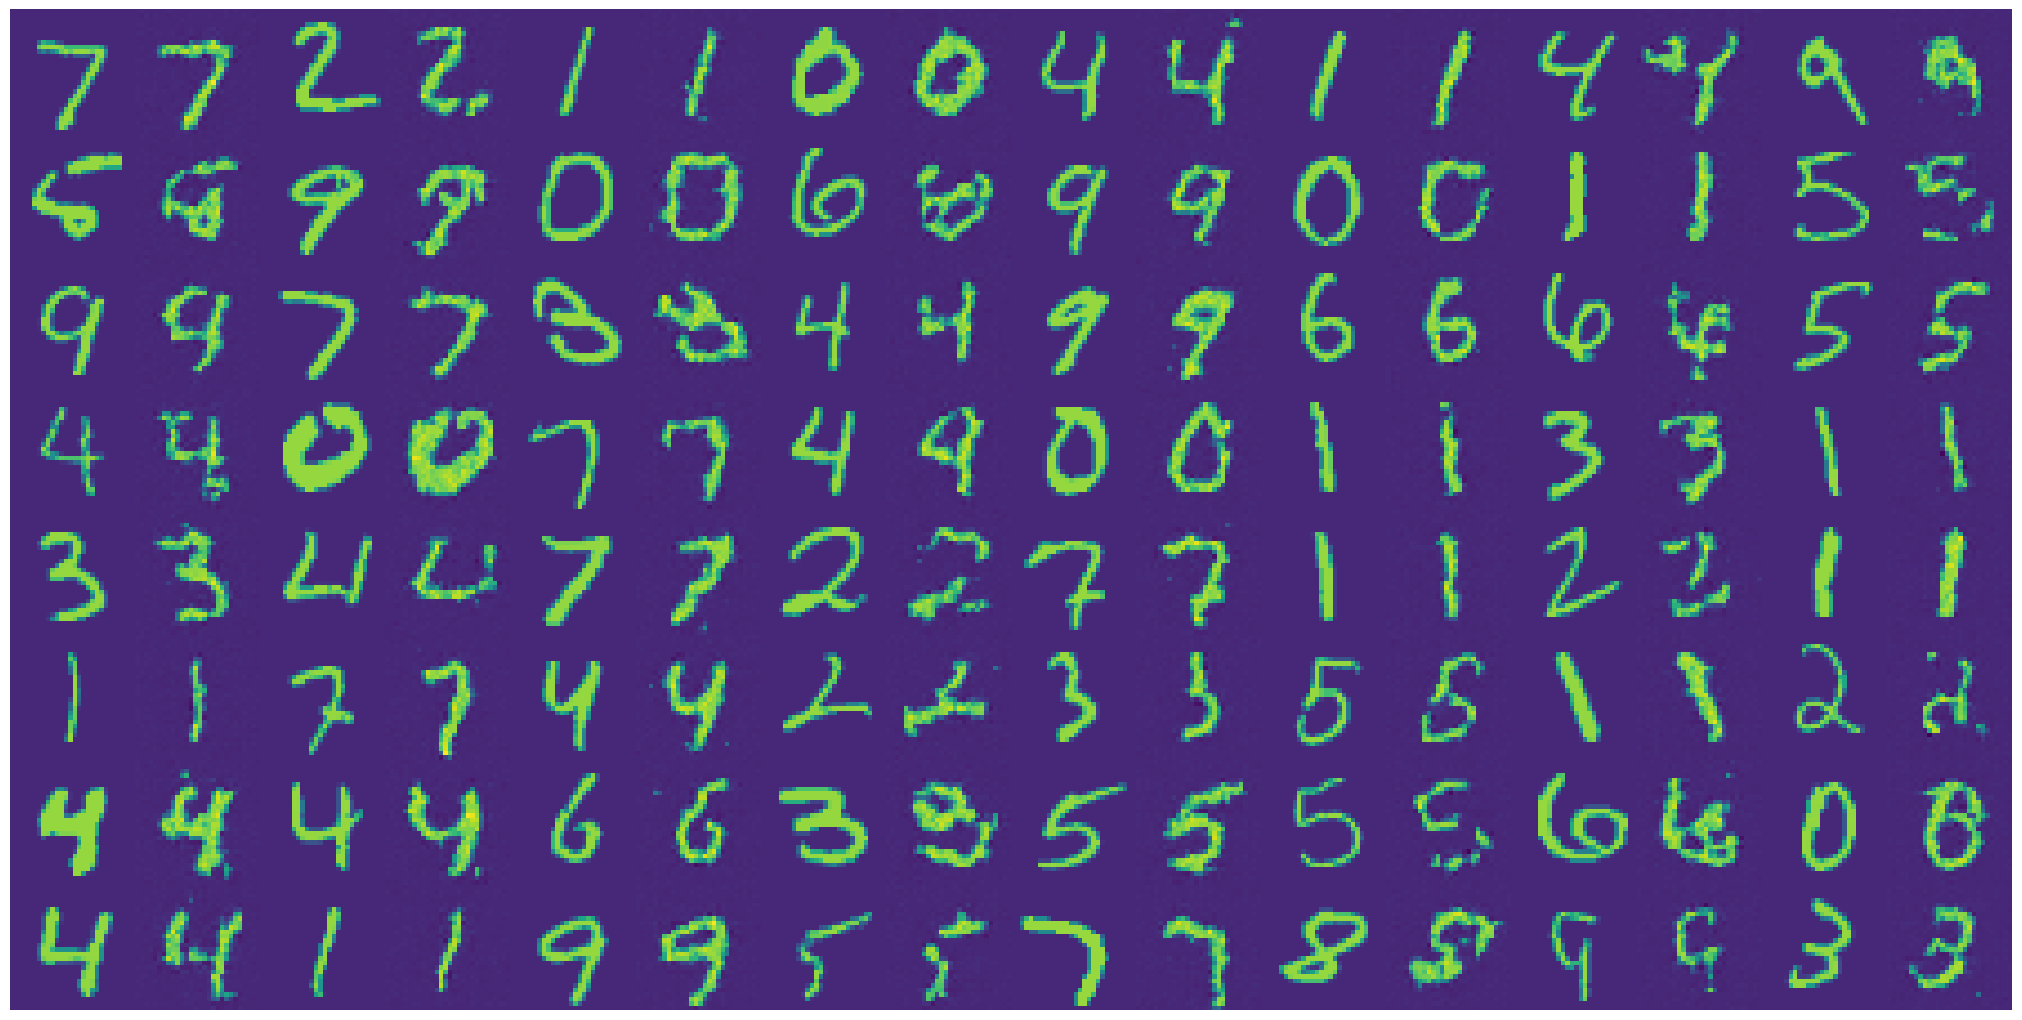

In [17]:
import matplotlib.pyplot as plt

x, y = next(iter(test_loader))
x = x.to(device).squeeze()
images = gen(model, x, denoising_steps=25)

images = rearrange([x, images], "l (eight1 eight2) h w -> (eight1 h) (eight2 l w)", eight1=8)
plt.figure(figsize=(26, 13))
plt.imshow(images.cpu().numpy())
plt.axis('off');